<a href="https://colab.research.google.com/github/SusanSagwa/Energy-Consumption-Prediction-In-Smart-Buildings-Using-Ensemble-Learning/blob/main/machine_project_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split

In [3]:
path = '../input/ashrae-energy-prediction'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/test.csv


In [4]:
dataset = pd.read_csv(f'{path}/train.csv')


In [5]:
trainData = dataset
trainData

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [6]:
dataset.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [7]:
buildingData = pd.read_csv(f'{path}/building_metadata.csv')

In [8]:
buildingData.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

# Merging building data with training data

In [9]:
data = dataset.merge(buildingData,on = 'building_id',how = 'left')

# Removing features having alot of nulls 

In [10]:
data = data.drop('year_built',axis = 1)
data = data.drop('floor_count',axis = 1)

In [11]:
weather_train = pd.read_csv(f'{path}/weather_train.csv')
weather_test = weather_df = pd.read_csv(f'{path}/weather_test.csv')

# Concatinating weather train and weather test data

In [12]:
import datetime as dt
frames = [weather_train,weather_test]
weather_data = pd.concat(frames)
data = data.merge(weather_data, on=['site_id', 'timestamp'], how='left')


# Converting timestamp feature to datetime to extract another features such as day,hour,month,and year

In [13]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data["day"]       = data["timestamp"].dt.day
data["hour"]      = data["timestamp"].dt.hour
data["week"]      = data["timestamp"].dt.weekday
data["month"]     = data["timestamp"].dt.month
data["year"]      = data["timestamp"].dt.year
data              = data.drop("timestamp", axis = 1)
del weather_data

In [14]:
data

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,hour,week,month,year
0,0,0,0.000,0,Education,7432,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
1,1,0,0.000,0,Education,2720,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
2,2,0,0.000,0,Education,5376,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
3,3,0,0.000,0,Education,23685,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
4,4,0,0.000,0,Education,116607,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,Entertainment/public assembly,19619,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016
20216096,1445,0,4.825,15,Education,4298,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016
20216097,1446,0,0.000,15,Entertainment/public assembly,11265,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016
20216098,1447,0,159.575,15,Lodging/residential,29775,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016


In [15]:
data.isnull().sum()

building_id                 0
meter                       0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature         96658
cloud_coverage        8825365
dew_temperature        100140
precip_depth_1_hr     3749023
sea_level_pressure    1231669
wind_direction        1449048
wind_speed             143676
day                         0
hour                        0
week                        0
month                       0
year                        0
dtype: int64

# Removing useless features

In [16]:
data.isnull().sum()

building_id                 0
meter                       0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature         96658
cloud_coverage        8825365
dew_temperature        100140
precip_depth_1_hr     3749023
sea_level_pressure    1231669
wind_direction        1449048
wind_speed             143676
day                         0
hour                        0
week                        0
month                       0
year                        0
dtype: int64

In [17]:
# precip_depth_1_hr
data = data.drop('cloud_coverage',axis = 1)
data

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,hour,week,month,year
0,0,0,0.000,0,Education,7432,25.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
1,1,0,0.000,0,Education,2720,25.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
2,2,0,0.000,0,Education,5376,25.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
3,3,0,0.000,0,Education,23685,25.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
4,4,0,0.000,0,Education,116607,25.0,20.0,NaN,1019.7,0.0,0.0,1,0,4,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,Entertainment/public assembly,19619,1.7,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016
20216096,1445,0,4.825,15,Education,4298,1.7,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016
20216097,1446,0,0.000,15,Entertainment/public assembly,11265,1.7,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016
20216098,1447,0,159.575,15,Lodging/residential,29775,1.7,-5.6,-1.0,1008.5,180.0,8.8,31,23,5,12,2016


In [18]:
data = data.drop(['wind_direction','sea_level_pressure'],axis=1)
data

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,day,hour,week,month,year
0,0,0,0.000,0,Education,7432,25.0,20.0,NaN,0.0,1,0,4,1,2016
1,1,0,0.000,0,Education,2720,25.0,20.0,NaN,0.0,1,0,4,1,2016
2,2,0,0.000,0,Education,5376,25.0,20.0,NaN,0.0,1,0,4,1,2016
3,3,0,0.000,0,Education,23685,25.0,20.0,NaN,0.0,1,0,4,1,2016
4,4,0,0.000,0,Education,116607,25.0,20.0,NaN,0.0,1,0,4,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,Entertainment/public assembly,19619,1.7,-5.6,-1.0,8.8,31,23,5,12,2016
20216096,1445,0,4.825,15,Education,4298,1.7,-5.6,-1.0,8.8,31,23,5,12,2016
20216097,1446,0,0.000,15,Entertainment/public assembly,11265,1.7,-5.6,-1.0,8.8,31,23,5,12,2016
20216098,1447,0,159.575,15,Lodging/residential,29775,1.7,-5.6,-1.0,8.8,31,23,5,12,2016


# Filling missing data

In [19]:
data['air_temperature'] = data['air_temperature'].fillna(data['air_temperature'].mean())
data['wind_speed'] = data['wind_speed'].fillna(data['wind_speed'].mean())
data['dew_temperature'] = data['dew_temperature'].fillna(data['dew_temperature'].mean())
data['precip_depth_1_hr'] = data['precip_depth_1_hr'].fillna(data['precip_depth_1_hr'].mean())

In [20]:
del dataset

In [21]:
data.describe()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,day,hour,week,month,year
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,20216100.0
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.598795e+01,7.747429e+00,7.964155e-01,3.377525e+00,1.576123e+01,1.150232e+01,3.006958e+00,6.578453e+00,2016.0
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,1.092109e+01,1.015343e+01,6.740961e+00,2.257628e+00,8.820535e+00,6.922017e+00,1.997191e+00,3.436662e+00,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,-2.890000e+01,-3.500000e+01,-1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2016.0
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,8.900000e+00,3.000000e-01,0.000000e+00,2.100000e+00,8.000000e+00,6.000000e+00,1.000000e+00,4.000000e+00,2016.0
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.670000e+01,8.900000e+00,0.000000e+00,3.100000e+00,1.600000e+01,1.200000e+01,3.000000e+00,7.000000e+00,2016.0
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,2.390000e+01,1.600000e+01,0.000000e+00,4.600000e+00,2.300000e+01,1.800000e+01,5.000000e+00,1.000000e+01,2016.0
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,4.720000e+01,2.610000e+01,3.430000e+02,1.900000e+01,3.100000e+01,2.300000e+01,6.000000e+00,1.200000e+01,2016.0


# Fixing site_id 0 error

In [22]:
data['meter_reading'] = [j*0.2931 if i == 0 else j for i,j in zip(data['site_id'],data['meter_reading'])]
data

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,day,hour,week,month,year
0,0,0,0.000,0,Education,7432,25.0,20.0,0.796416,0.0,1,0,4,1,2016
1,1,0,0.000,0,Education,2720,25.0,20.0,0.796416,0.0,1,0,4,1,2016
2,2,0,0.000,0,Education,5376,25.0,20.0,0.796416,0.0,1,0,4,1,2016
3,3,0,0.000,0,Education,23685,25.0,20.0,0.796416,0.0,1,0,4,1,2016
4,4,0,0.000,0,Education,116607,25.0,20.0,0.796416,0.0,1,0,4,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,Entertainment/public assembly,19619,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016
20216096,1445,0,4.825,15,Education,4298,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016
20216097,1446,0,0.000,15,Entertainment/public assembly,11265,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016
20216098,1447,0,159.575,15,Lodging/residential,29775,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016


In [23]:
meter_values = data['meter'].unique()
meter_values

array([0, 3, 1, 2])

# Filtering buildings that use electricity meter

In [24]:
electricMeter = data[data['meter']==0]


# Converting primary use to numiric

In [25]:
from sklearn.preprocessing import LabelEncoder

In [26]:
le = LabelEncoder()
data['primary_use'] = le.fit_transform(data['primary_use'])

In [27]:
data

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,day,hour,week,month,year
0,0,0,0.000,0,0,7432,25.0,20.0,0.796416,0.0,1,0,4,1,2016
1,1,0,0.000,0,0,2720,25.0,20.0,0.796416,0.0,1,0,4,1,2016
2,2,0,0.000,0,0,5376,25.0,20.0,0.796416,0.0,1,0,4,1,2016
3,3,0,0.000,0,0,23685,25.0,20.0,0.796416,0.0,1,0,4,1,2016
4,4,0,0.000,0,0,116607,25.0,20.0,0.796416,0.0,1,0,4,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,1,19619,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016
20216096,1445,0,4.825,15,0,4298,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016
20216097,1446,0,0.000,15,1,11265,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016
20216098,1447,0,159.575,15,4,29775,1.7,-5.6,-1.000000,8.8,31,23,5,12,2016


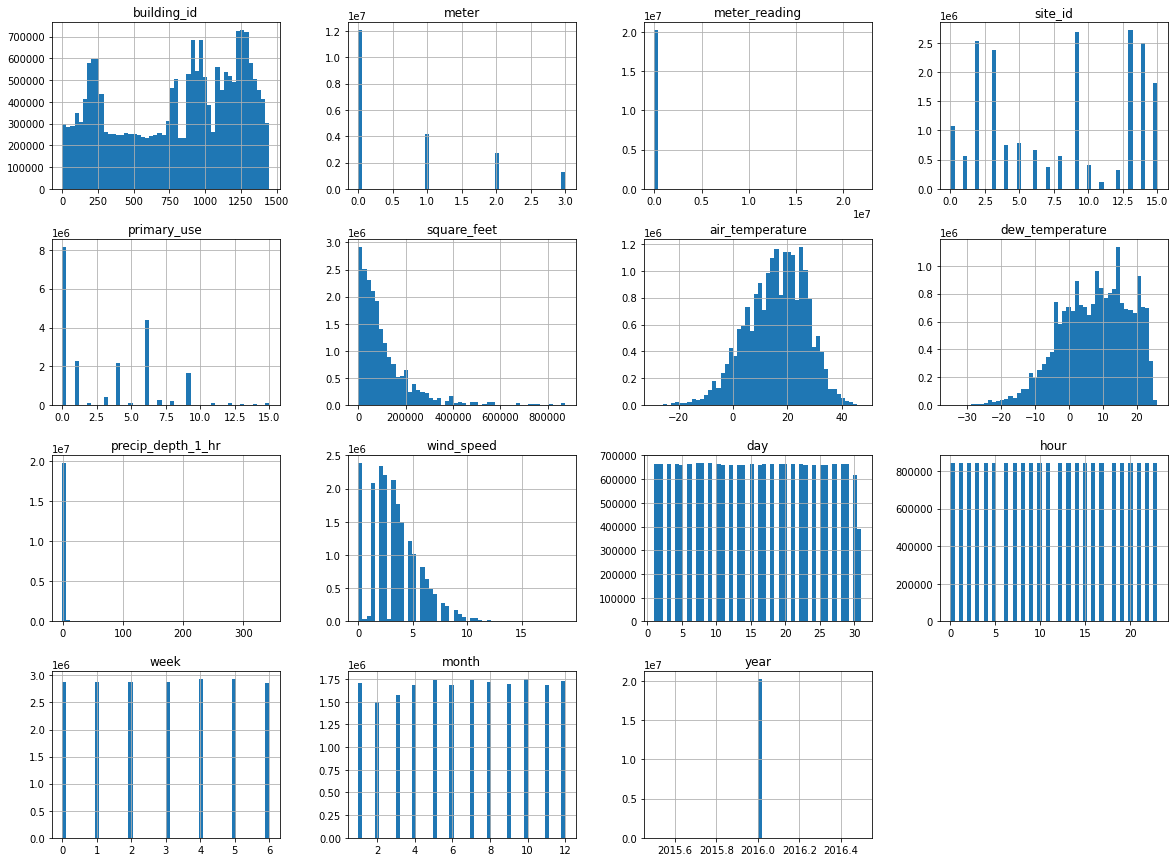

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20, 15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [29]:
data.corr()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,day,hour,week,month,year
building_id,1.000000,0.222268,0.008997,0.980975,0.058236,0.087704,-0.313021,-0.109690,0.020170,0.003667,-0.000363,-0.000051,-0.000049,0.014516,NaN
meter,0.222268,1.000000,0.017673,0.253875,-0.081760,0.132708,-0.011133,-0.080252,-0.002071,-0.080881,0.000020,0.000108,-0.000057,0.005292,NaN
meter_reading,0.008997,0.017673,1.000000,0.012108,-0.009899,0.024303,-0.004248,-0.003489,0.000495,0.006082,-0.000046,0.000591,-0.000732,-0.006733,NaN
site_id,0.980975,0.253875,0.012108,1.000000,0.076996,0.090934,-0.306074,-0.134683,0.019871,0.011515,-0.000471,-0.000069,-0.000037,0.014447,NaN
primary_use,0.058236,-0.081760,-0.009899,0.076996,1.000000,-0.086636,-0.043365,-0.013617,0.004404,0.052248,0.000182,-0.000057,-0.000233,-0.002255,NaN
square_feet,0.087704,0.132708,0.024303,0.090934,-0.086636,1.000000,-0.015630,-0.023328,0.002201,-0.034777,-0.000333,0.000027,0.000222,-0.002829,NaN
air_temperature,-0.313021,-0.011133,-0.004248,-0.306074,-0.043365,-0.015630,1.000000,0.750570,-0.003922,-0.081645,0.020024,0.117840,-0.006130,0.168050,NaN
dew_temperature,-0.109690,-0.080252,-0.003489,-0.134683,-0.013617,-0.023328,0.750570,1.000000,0.066436,-0.141687,0.018827,-0.000110,-0.003033,0.241105,NaN
precip_depth_1_hr,0.020170,-0.002071,0.000495,0.019871,0.004404,0.002201,-0.003922,0.066436,1.000000,0.031044,0.002822,0.002466,-0.000241,0.006638,NaN
wind_speed,0.003667,-0.080881,0.006082,0.011515,0.052248,-0.034777,-0.081645,-0.141687,0.031044,1.000000,-0.010640,0.150141,0.002623,-0.069176,NaN


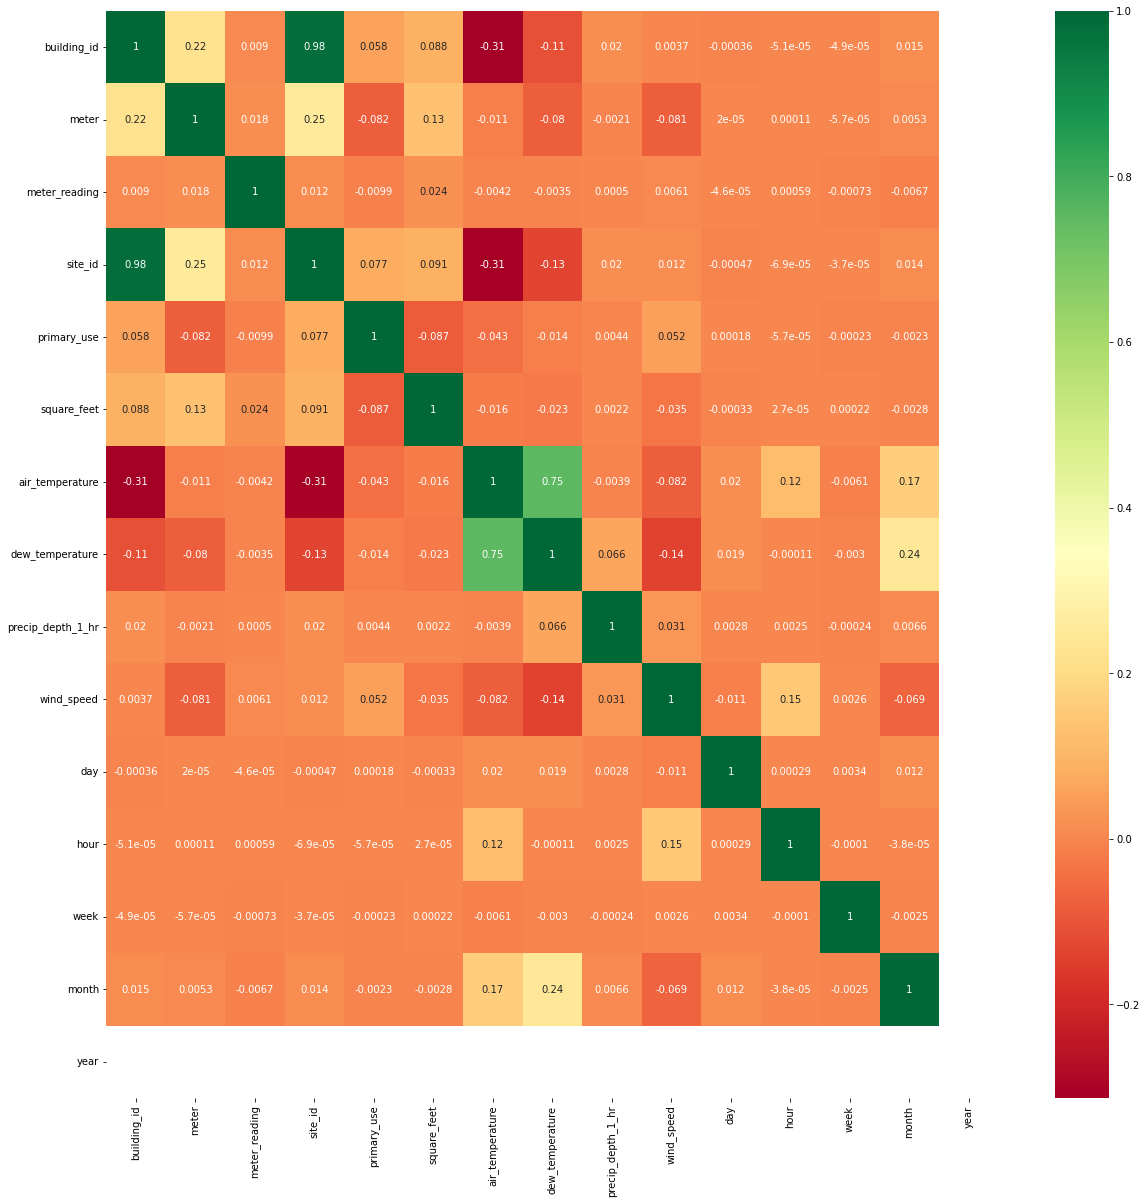

In [30]:
corrmap = data.corr()
top_corr_features = corrmap.index
plt.figure(figsize=(20,20))
#making of heatmap
df_heatmap = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [31]:
sorted_meterreading = data.sort_values('meter_reading', ascending=False)
sorted_meterreading.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed,day,hour,week,month,year
8907488,1099,2,21904700.0,13,0,332884,19.4,17.2,0.0,6.2,13,9,0,6,2016
8738539,1099,2,21889900.0,13,0,332884,21.1,17.8,0.0,5.1,10,9,4,6,2016
8736187,1099,2,21874500.0,13,0,332884,21.1,17.8,0.0,6.2,10,8,4,6,2016
17286421,1099,2,21847900.0,13,0,332884,3.9,1.1,0.0,2.1,9,14,2,11,2016
8905140,1099,2,21844500.0,13,0,332884,20.0,17.2,8.0,3.6,13,8,0,6,2016


In [32]:
def daily(x,data=data):
    return data.groupby('weekday')[x].mean()
def hourly(x,data=data):
    return data.groupby('hour')[x].mean()

def monthly_daily(x,data=data):
    by_day = data.pivot_table(index='weekday', 
                                columns=['month'],
                                values=x,
                                aggfunc='mean')
    return round(by_day, ndigits=2)

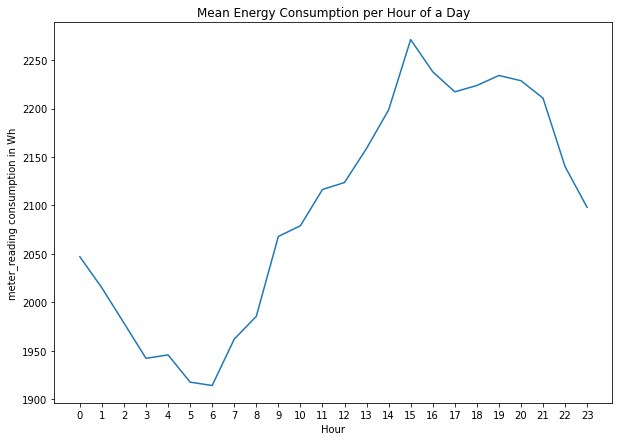

In [33]:
#plotting the hourly consumption

hourly('meter_reading').plot(figsize=(10,7))
plt.xlabel('Hour')
plt.ylabel('meter_reading consumption in Wh')
ticks = list(range(0, 24, 1))
plt.title('Mean Energy Consumption per Hour of a Day')

plt.xticks(ticks);

**Training The model**

In [34]:
data.meter_reading = data.meter_reading.astype(float)
Y =data['meter_reading']

In [35]:
Y

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
20216095      8.750
20216096      4.825
20216097      0.000
20216098    159.575
20216099      2.850
Name: meter_reading, Length: 20216100, dtype: float64

In [36]:
X =data.drop(data.loc[:,['meter_reading','hour','week','day','month','year']],axis=1)

In [37]:
X.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed
0,0,0,0,0,7432,25.0,20.0,0.796416,0.0
1,1,0,0,0,2720,25.0,20.0,0.796416,0.0
2,2,0,0,0,5376,25.0,20.0,0.796416,0.0
3,3,0,0,0,23685,25.0,20.0,0.796416,0.0
4,4,0,0,0,116607,25.0,20.0,0.796416,0.0


**Spliting data to train, test**

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 

In [39]:
y_test

14245562      0.000000
1282718      32.000100
13883790    567.655000
4781820       0.000000
10415393     65.750000
               ...    
3596267      62.820000
7144295     527.985000
4245183     115.935000
18177875      9.620000
14328281     74.231092
Name: meter_reading, Length: 4043220, dtype: float64

In [40]:
print(len(x_train),len(x_test),len(y_train),len(y_test))

16172880 4043220 16172880 4043220


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

**Decision Tree**

In [42]:
parameters = {'max_depth': [3,5,7,9,11,15]}


decission_tree = GridSearchCV(estimator = DecisionTreeRegressor(),
                        param_grid = parameters,
                        cv = 3, 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [43]:
print("Best Decision Tree Estimator ",decission_tree.best_estimator_)
print("Best Decision Tree Paramteres are : ", decission_tree.best_params_)

Best Decision Tree Estimator  DecisionTreeRegressor(max_depth=9)
Best Decision Tree Paramteres are :  {'max_depth': 9}


In [44]:
DecissionTree = DecisionTreeRegressor(max_depth=15)
DecissionTree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=15)

**Svm**

In [ ]:
from sklearn import svm

svr_model = svm.SVR(gamma ='scale')
fit_model = svr_model.fit(x_train , y_train) 

**Ensemble**

In [ ]:
estimators = [
              ('svr_model', SVR()),
              ('decission_tree', DecisionTreeRegressor())]

In [ ]:
final_estimator = GradientBoostingRegressor(
        n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
        random_state=42)
Ensemble_model = StackingRegressor(
      estimators=estimators,
      final_estimator=final_estimator)

In [ ]:
Ensemble_model.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    r_score = 100*r2_score(test_labels,predictions)
    accuracy = 100 - mape
    print(model,'\n')
    print('Average Error(Mean Absolute Error)       : {:0.4f} degrees'.format(np.mean(errors)))
    print('Variance score R^2  : {:0.2f}%' .format(r_score))
    print('Accuracy            : {:0.2f}%\n'.format(accuracy)) 

In [ ]:
evaluate(svr_model, x_test, y_test)
evaluate(decission_tree, x_test, y_test)
evaluate(Ensemble_model, x_test, y_test)

In [ ]:
y1_pred = Ensemble_model.predict(x_test)
len(y1_pred)

In [ ]:
y1_pred

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test[:100].values,label='Target value',color='b')
plt.plot(y1_pred[:100],label='Ensemble Learner ', linestyle='--', color='g')

plt.legend(loc=1)

In [ ]:
# save the file for deployment

import pickle
file = open('EnsembleModel.pkl','wb')
pickle.dump(Ensemble_model,file)
file.close()